# BraTS2020 Brain Tumor Segmentation

Takes data from https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation, which is from the BraTS2020 Competition. <br><br> There are 4 goals of the project:
1. Manual segmentation labels of tumor sub-regions,
2. Clinical data of overall survival,
3. Clinical evaluation of progression status,
4. Uncertainty estimation for the predicted tumor sub-regions.

This file is for goal #1: Brain tumor segmentation utilizing the MRI data.

## 1. Download Dataset

In [ ]:
#! pip install kaggle

In [ ]:
# Set your working directory first so the data downloads where you want
#! kaggle datasets download awsaf49/brats20-dataset-training-validation

In [ ]:
#! unzip brats20-dataset-training-validation.zip

## 2. Load/Explore Data

### Setup Imports

In [67]:
import monai
import os
import torch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import time
import onnxruntime
import random
import cv2
import PIL
from PIL import Image, ImageOps
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate, resize
import glob
from tqdm import tqdm

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, compute_confusion_matrix_metric
from monai.networks.nets import SegResNet
from monai.utils import set_determinism
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandRotate90d,
    RandZoomd,
    Resized,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ScaleIntensityd,
)


print_config()

MONAI version: 1.3.2
Numpy version: 1.23.5
Pytorch version: 2.2.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /Users/<username>/opt/anaconda3/envs/monai_env/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.17.2
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.45.0
mlflow version: 2.16.2
pynrrd version: 1.0.0
clearml version: 1.16.4

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Setup Environment and Directory

In [68]:
os.environ["MONAI_DATA_DIRECTORY"] = os.path.expanduser('~/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Individual Work/Deep Learning/MONAI/Brain Tumor')
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
# List all directories in the given path
folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]

# Print the folders
print(folders)

/Users/jarrettsung/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Individual Work/Deep Learning/MONAI/Brain Tumor
['BraTS2020_ValidationData', '.ipynb_checkpoints', 'BraTS2020_TrainingData']


### Rename files that are incorrectly named
The segmentation file in "BraTS20_Training_355" folder has an incorrect name. Before moving forward, rename it to maintain similarity.

In [ ]:
# Set path to 355 folder for renaming
rename_PATH = root_dir + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/"
print(rename_PATH)

In [ ]:
old_name = rename_PATH + "W39_1998.09.19_Segm.nii"
new_name = rename_PATH + "BraTS20_Training_355_seg.nii"

try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

### Explore Data
Now that the files are named correctly, we can explore the data. <br><br> Let's take a look at patient 147 as an example.

In [ ]:
# load .nii file as a numpy array
test_PATH = root_dir + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
test_image_flair = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

#### Scale Data for Viewing
The max is a little high for our liking, so let's scale the data, just using minmax

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Scale the image and then reshape it back to original dimensions
# Keeps spatial structure while standardizing it
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [ ]:
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Let's rescale the rest of the images from patient 147

In [ ]:
# Rescale t1
test_image_t1 = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_t1.nii").get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# Rescale t1ce
test_image_t1ce = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_t1ce.nii").get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# Rescale t2
test_image_t2 = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_t2.nii").get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# Don't want to rescale the mask - let's explore it before doing anything to it
# Mask (seg)
test_image_seg = nib.load(test_PATH + "BraTS20_Training_147/BraTS20_Training_147_seg.nii").get_fdata()


#### View by slice
Now that we've rescaled, let's take a look at the images for a couple of different slices. Let's arbitrarily pick slice 95 and slice 105.

In [ ]:
slice = 95

print("Slice number: ", str(slice)) 

# Let's also check the shapes of the images t1 and mask
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

plt.figure(figsize=(12,8))

# Plot T1
plt.subplot(2,3,1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# Plot T1CE
plt.subplot(2,3,2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1CE')

# Plot T2
plt.subplot(2,3,3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Plot FLAIR
plt.subplot(2,3,4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('Flair')

# Plot Mask (Seg)
plt.subplot(2,3,5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')

plt.show()

In [ ]:
slice = 105

print("Slice number: ", str(slice)) 

# Let's also check the shapes of the images t1 and mask
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

plt.figure(figsize=(12,8))

# Plot T1
plt.subplot(2,3,1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# Plot T1CE
plt.subplot(2,3,2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1CE')

# Plot T2
plt.subplot(2,3,3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Plot FLAIR
plt.subplot(2,3,4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('Flair')

# Plot Mask (Seg)
plt.subplot(2,3,5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')

plt.show()

#### View all slices
It's pretty easy to tell at this point that depending on the slice, the images will show different things. We can then take a look at all slices and see if each will give different information, important or not.

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)

# Montage helps show all of the images
plt.imshow(rotate(montage(test_image_t2[:,:,:]), 90, resize=True), cmap='gray')
plt.show()

The sides of the image are dark, which means they don't contain much useful information. Let's remove 50 slices from each side to see if all important information is contained. Can adjust number of slices if needed.

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,1,1)

# Let's remove 50 slices on each side since there's not much information from them
plt.imshow(rotate(montage(test_image_t2[50:-50,:,:]), 90, resize=True), cmap='gray')
plt.show()

#### Look at different viewpoints
Next, let's take a look at the different views of a single slice. We'll look at the transverse view (above), the frontal view, and the saggital view (side). <br> <br>
We do this because the different viewpoints can give us different understandings of the images.

In [ ]:
slice = 95

print("Slice: ", str(slice))

plt.figure(figsize=(12,8))

# Transverse view
plt.subplot(1,3,1)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title("Transverse View")

# Frontal view
plt.subplot(1,3,2)
plt.imshow(rotate(test_image_t2[:,slice,:], 90, resize=True), cmap='gray')
plt.title("Frontal View")

# Saggital view
plt.subplot(1,3,3)
plt.imshow(rotate(test_image_t2[slice,:,:], 90, resize=True), cmap='gray')
plt.title("Saggital View")

plt.show()

#### Segmented images
Now that we've viewed much of the data, let's focus on the segmented images.<br><br>
There are 4 important classes in the segmented images:
1. Not Tumor (class 0)
2. Non-Enhancing Tumor (class 1)
3. Edema (class 2)
4. Enhancing Tumor (class 4)<br>

We'll now take a look at each of them separately

In [ ]:
slice = 95
print("Slice: ", str(slice))

# Lets define the classes and the coloring scheme
cmap = matplotlib.colors.ListedColormap(['#500050', '#0096FF', '#00FF00', '#CCCC00'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Not Tumor (class 0)
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Non-Enhancing Tumor (class 1)
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Edema (class 2)
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Enhancing Tumor (class 4)
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define class names for legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0,0),1,1, color = cmap(i), label = class_names[i]) for i in range(len(class_names))] 


plt.figure(figsize=(20,20))

plt.subplot(1,5,1)
plt.imshow(test_image_seg[:,:,slice], cmap=cmap, norm=norm)
plt.title('Full Mask')
plt.legend(handles=legend, loc='lower left')

plt.subplot(1,5,2)
plt.imshow(seg_0[:,:,slice], cmap=cmap, norm=norm)
plt.title('Seg 0')
plt.legend(handles=legend, loc='lower left')

plt.subplot(1,5,3)
plt.imshow(seg_1[:,:,slice], cmap=cmap, norm=norm)
plt.title('Seg 1')
plt.legend(handles=legend, loc='lower left')

plt.subplot(1,5,4)
plt.imshow(seg_2[:,:,slice], cmap=cmap, norm=norm)
plt.title('Seg 2')
plt.legend(handles=legend, loc='lower left')

plt.subplot(1,5,5)
plt.imshow(seg_4[:,:,slice], cmap=cmap, norm=norm)
plt.title('Seg 4')
plt.legend(handles=legend, loc='lower left')

plt.show()

## 3. Split the Data

In [69]:
# Define the path to your training data directory
train_data_dir = root_dir + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Get all patient directories in the training set
train_dirs = sorted(glob.glob(os.path.join(train_data_dir, "BraTS20_Training_*")))

# Create a list of dictionaries, where each dictionary contains paths to the modalities and segmentation
train_and_test_files = []
for train_dir in train_dirs:
    data_dict = {
        "t1ce": os.path.join(train_dir, f"{os.path.basename(train_dir)}_t1ce.nii"),
        "flair": os.path.join(train_dir, f"{os.path.basename(train_dir)}_flair.nii"),
        "seg": os.path.join(train_dir, f"{os.path.basename(train_dir)}_seg.nii"),
    }
    train_and_test_files.append(data_dict)

# Print the number of training patients
print(f"Total number of patients: {len(train_and_test_files)}")

Total number of patients: 369


Since we don't have a defined test set, we can split the validation set randomly to get a train/val/test split to about 65/20/15

In [70]:
# Split the data into train/test and validation (20% validation)
train_test_files, val_files = train_test_split(train_and_test_files,test_size=0.2)

# Split the train/test into train (68% train) and test (12% test)
train_files, test_files = train_test_split(train_test_files,test_size=0.15)

In [71]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_files)}")
print(f"Validation length: {len(val_files)}")
print(f"Test length: {len(test_files)}")

Train length: 250
Validation length: 74
Test length: 45


In [ ]:
plt.bar(["Train","Valid","Test"],
        [len(train_files), len(val_files), len(test_files)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

## 4. Define Transformations for the data

In [72]:
common_size = (240, 240, 160)  # Ensure a common size for spatial dimensions

class ReassignClasses:
    def __call__(self, data):
        seg = data['seg']
        seg[seg == 4] = 3  # Reassign class 4 to class 3
        data['seg'] = seg
        return data

# Define transformations for training, validation, and test datasets
train_transforms = Compose(
    [
        LoadImaged(keys=["t1ce","flair", "seg"]),  # Load images from file paths
        EnsureChannelFirstd(keys=["t1ce","flair", "seg"]),  # Ensure channels are first
        ScaleIntensityd(keys=["t1ce","flair"]),  # Normalize intensity values
        Resized(keys=["t1ce", "flair", "seg"], spatial_size=common_size), # Ensure common size
        RandFlipd(keys=["t1ce","flair", "seg"], spatial_axis=0, prob=0.5),  # Random flip
        RandRotate90d(keys=["t1ce","flair", "seg"], prob=0.5),  # Random 90 degree rotation
        RandZoomd(keys=["t1ce","flair", "seg"], min_zoom=0.9, max_zoom=1.1, prob=0.5),  # Random zoom
        ReassignClasses(),
        AsDiscreted(keys=["seg"], to_onehot=4),
        EnsureTyped(keys=["t1ce","flair", "seg"]) # Ensure tensors
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["t1ce", "flair", "seg"]),  # Load images from file paths
        EnsureChannelFirstd(keys=["t1ce", "flair", "seg"]),  # Ensure channels are first
        ScaleIntensityd(keys=["t1ce", "flair"]),  # Normalize intensity values
        Resized(keys=["t1ce", "flair", "seg"], spatial_size=common_size),  # Resize images
        ReassignClasses(),  # Reassign segmentation labels
        EnsureTyped(keys=["t1ce", "flair", "seg"]),  # Ensure tensors
        AsDiscreted(keys=["seg"], to_onehot=4)  # One-hot encoding for segmentation
    ]
)

## 5. Create DataLoaders for split data

In [73]:
# Create MONAI datasets for training, new validation, and test sets
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
test_ds = Dataset(data=test_files, transform=val_transforms)  # Test set with no augmentation

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=2, num_workers=0)

# Print data loader sizes
print(f"Training DataLoader size: {len(train_loader)}")
print(f"Validation DataLoader size: {len(val_loader)}")
print(f"Test DataLoader size: {len(test_loader)}")

Training DataLoader size: 125
Validation DataLoader size: 37
Test DataLoader size: 23


In [ ]:
for batch_data in train_loader:
    print(batch_data)
    break

In [ ]:
for batch_data in train_loader:
    inputs = batch_data["t1ce"]
    labels = batch_data["seg"]
    print(f"Input size: {inputs.shape}, Label size: {labels.shape}")
    if (inputs.shape != labels.shape): 
        print("Mismatch on t1ce")
        break
    inputs2 = batch_data["flair"]
    print(f"Input size: {inputs2.shape}, Label size: {labels.shape}")
    if (inputs2.shape != labels.shape): 
        print("Mismatch on flair")
        break

## 6. Create model, loss function, optimizer

In [74]:
max_epochs = 4
val_interval = 1
VAL_AMP = False

# Define the model
device = torch.device("cpu")
model = SegResNet(
    blocks_down = [1, 2, 2, 4],
    blocks_up = [1, 1, 1],
    init_filters = 8,
    in_channels = 2,
    out_channels = 4,
    dropout_prob = 0.2,
).to(device)

# Define loss function, optimizer, learning rate scheduler
loss_function = DiceLoss(
    smooth_nr = 0,
    smooth_dr = 1e-5,
    squared_pred = True,
    to_onehot_y = False,
    sigmoid = True
)
# SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
# Step LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Metrics and post-processing
dice_metric = DiceMetric(include_background = True, reduction = "mean")
dice_metric_batch = DiceMetric(include_background = True, reduction = "mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# Define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )
    return _compute(input)

torch.backends.cudnn.benchmark = False

## 7. Train the data

In [75]:
best_metric = -1
best_metric_epoch = -1
best_metric_epoch_time = [[], [], []]
epoch_loss_val = []
metric_val = []
metric_val_tc = []
metric_val_wt = []
metric_val_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train() # start training the model
    epoch_loss = 0
    step = 0

    # Iterate through batches
    for batch_data in train_loader:
        step_start = time.time()
        step += 1

        inputs = torch.cat([ 
                        batch_data["t1ce"].to(device), 
                        batch_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
        labels = batch_data["seg"].to(device)  # Segmentation labels

        optimizer.zero_grad() # Reset gradients

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backprop
        loss.backward()
        optimizer.step() # Update parameters

        # Accumulate total epoch loss
        epoch_loss += loss.item()
        
        # Update training progress
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )

     # Update learning rate scheduler
    lr_scheduler.step()

    # Calc/store average loss for epoch
    epoch_loss /= step
    epoch_loss_val.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Validation at intervals
    if (epoch + 1) % val_interval == 0:
        model.eval() # Evaluation mode
        with torch.no_grad(): # Don't want gradients when validating
            for val_data in val_loader:
                val_inputs = torch.cat([
                    val_data["t1ce"].to(device),
                    val_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
                val_labels = val_data["seg"].to(device)  # Segmentation labels

                # Make prediction
                val_outputs = inference(val_inputs)

                # Post-process outputs
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                # Compute Dice metric for each batch
                dice_metric(y_pred = val_outputs, y = val_labels)
                dice_metric_batch(y_pred = val_outputs, y = val_labels)

            # Aggregate/store validation metrics
            metric = dice_metric.aggregate().item()
            metric_val.append(metric)

            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_val_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_val_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_val_et.append(metric_et)
            
            # Reset metrics for next epoch
            dice_metric.reset()
            dice_metric_batch.reset()
            
            # Save model if current metric is the best
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metric_epoch_time[0].append(best_metric)
                best_metric_epoch_time[1].append(best_metric_epoch)
                best_metric_epoch_time[2].append(time.time() - total_start)
                
                # Save model
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth")
                )
                print("saved new best metric model")

            # Print best metrics
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
   
    # Time spent for each epoch
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")


# Calc total training time
total_time = time.time() - total_start
print(f"Total time: {total_time:.4f}")

----------
epoch 1/4
1/125, train_loss: 0.7888, step time: 59.6621
2/125, train_loss: 0.7875, step time: 52.0519
3/125, train_loss: 0.7954, step time: 47.1155
4/125, train_loss: 0.7844, step time: 46.9851
5/125, train_loss: 0.7931, step time: 45.7215
6/125, train_loss: 0.7820, step time: 45.9213
7/125, train_loss: 0.7853, step time: 45.2195
8/125, train_loss: 0.7849, step time: 46.8199
9/125, train_loss: 0.7887, step time: 44.7136
10/125, train_loss: 0.7829, step time: 46.7098
11/125, train_loss: 0.7786, step time: 44.1343
12/125, train_loss: 0.7805, step time: 46.7339
13/125, train_loss: 0.7798, step time: 54.0005
14/125, train_loss: 0.7802, step time: 44.2834
15/125, train_loss: 0.7798, step time: 43.2860
16/125, train_loss: 0.7858, step time: 42.2726
17/125, train_loss: 0.7806, step time: 41.9762
18/125, train_loss: 0.7863, step time: 43.8354
19/125, train_loss: 0.7823, step time: 42.1628
20/125, train_loss: 0.7769, step time: 41.5836
21/125, train_loss: 0.7727, step time: 41.8183
2

#### Debugging training

In [ ]:
# Use a smaller subset of data for debugging
small_train_files = train_files[:10]  # Just take the first 10 patients
small_val_files = val_files[:5]  # Just take 5 for validation
small_test_files = test_files

# Create DataLoaders for the smaller datasets
small_train_loader = DataLoader(Dataset(data=small_train_files, transform=train_transforms), batch_size=1, shuffle=True, num_workers=0)
small_val_loader = DataLoader(Dataset(data=small_val_files, transform=val_transforms), batch_size=1, shuffle=False, num_workers=0)
small_test_loader = DataLoader(Dataset(data=small_test_files, transform=val_transforms), batch_size=1, shuffle=False, num_workers=0)



In [ ]:
class ReassignClasses:
    def __call__(self, data):
        seg = data['seg']
        #print(f"Seg before reassignment: {seg.shape} -- {type(seg)}")  # Debug print
        seg[seg == 4] = 3  # Reassign class 4 to class 3
        data['seg'] = seg
        #print(f"Seg after reassignment: {seg.shape} -- {type(seg)}")  # Debug print
        return data

val_transforms = Compose(
    [
        LoadImaged(keys=["t1ce", "flair", "seg"]),  # Load images from file paths
        EnsureChannelFirstd(keys=["t1ce", "flair", "seg"]),  # Ensure channels are first
        ScaleIntensityd(keys=["t1ce", "flair"]),  # Normalize intensity values
        Resized(keys=["t1ce", "flair", "seg"], spatial_size=common_size),  # Resize images
        ReassignClasses(),  # Reassign segmentation labels
        EnsureTyped(keys=["t1ce", "flair", "seg"]),  # Ensure tensors
        AsDiscreted(keys=["seg"], to_onehot=4)  # One-hot encoding for segmentation
    ]
)



In [ ]:
for val_data in small_val_loader:
    print(val_data)  # Print the data dictionary to inspect what is being passed
    val_inputs, val_labels = (
        val_data["t1ce"].to(device),
        val_data["seg"].to(device)
    )
    print(f"Validation Inputs: {val_inputs.shape}")
    print(f"Validation Labels: {val_labels.shape}")

In [ ]:
model.eval()
with torch.no_grad():
    for val_data in small_val_loader:
        val_inputs = torch.cat([
            val_data["t1ce"].to(device),
            val_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
        val_labels = val_data["seg"].to(device)  # Segmentation labels

        # Forward pass
        val_outputs = model(val_inputs)

        # Print shapes
        print(f"Model Output Shape: {val_outputs.shape}")
        print(f"Validation Labels Shape: {val_labels.shape}")

        #break  # Check only one batch for now

In [ ]:

for batch_data in small_train_loader:
    inputs = torch.cat([ 
                        batch_data["t1ce"].to(device), 
                        batch_data["flair"].to(device)], dim=1)
    labels = batch_data["seg"].to(device)
    
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    #break  # Only run the first batch for debugging


In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metric_epoch_time = [[], [], []]
epoch_loss_val = []
metric_val = []
metric_val_tc = []
metric_val_wt = []
metric_val_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train() # start training the model
    epoch_loss = 0
    step = 0

    # Iterate through batches
    for batch_data in small_train_loader:
        step_start = time.time()
        step += 1

        inputs = torch.cat([ 
                        batch_data["t1ce"].to(device), 
                        batch_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
        labels = batch_data["seg"].to(device)  # Segmentation labels

        optimizer.zero_grad() # Reset gradients

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backprop
        loss.backward()
        optimizer.step() # Update parameters

        # Accumulate total epoch loss
        epoch_loss += loss.item()
        
        # Update training progress
        print(
            f"{step}/{10 // small_train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )

     # Update learning rate scheduler
    lr_scheduler.step()

    # Calc/store average loss for epoch
    epoch_loss /= step
    epoch_loss_val.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Validation at intervals
    if (epoch + 1) % val_interval == 0:
        model.eval() # Evaluation mode
        with torch.no_grad(): # Don't want gradients when validating
            for val_data in small_val_loader:
                val_inputs = torch.cat([
                    val_data["t1ce"].to(device),
                    val_data["flair"].to(device)], dim=1)  # Concatenating along the channel axis
                val_labels = val_data["seg"].to(device)  # Segmentation labels

                # Make prediction
                val_outputs = inference(val_inputs)

                # Post-process outputs
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                # Compute Dice metric for each batch
                dice_metric(y_pred = val_outputs, y = val_labels)
                dice_metric_batch(y_pred = val_outputs, y = val_labels)

            # Aggregate/store validation metrics
            metric = dice_metric.aggregate().item()
            metric_val.append(metric)

            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_val_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_val_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_val_et.append(metric_et)
            
            # Reset metrics for next epoch
            dice_metric.reset()
            dice_metric_batch.reset()
            
            # Save model if current metric is the best
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metric_epoch_time[0].append(best_metric)
                best_metric_epoch_time[1].append(best_metric_epoch)
                best_metric_epoch_time[2].append(time.time() - total_start)
                
                # Save model
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth")
                )
                print("saved new best metric model")

            # Print best metrics
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
   
    # Time spent for each epoch
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")


# Calc total training time
total_time = time.time() - total_start
print(f"Total time: {total_time:.4f}")

## 8. Evaluate the Model on Test Set

In [76]:
# Load the best model
model.load_state_dict(torch.load(root_dir + "/best_metric_model.pth", map_location=device))

<All keys matched successfully>

In [77]:
# Metrics for evaluation
dice_metric = DiceMetric(include_background=False, reduction="mean_batch")

# Post-processing: apply activation and thresholding for segmentation
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

model.eval()  # Set model to evaluation mode
dice_scores = []

with torch.no_grad():
    for idx, test_data in enumerate(test_loader):
        # Prepare test inputs by concatenating T1CE and FLAIR along the channel axis
        test_inputs = torch.cat([
            test_data['t1ce'].to(device),
            test_data['flair'].to(device)], dim=1) 
        
        test_labels = test_data['seg'].to(device)  # Get segmentation labels
        
        # Forward pass through the model
        outputs = model(test_inputs)

        # Post-processing outputs
        outputs = [post_trans(i) for i in decollate_batch(outputs)]

        # Compute Dice metric for this batch
        dice_metric(y_pred=outputs, y=test_labels)
        
        # Get the Dice score for the batch and append to dice_scores list
        dice_score_batch = dice_metric.aggregate().mean().item()
        dice_scores.append(dice_score_batch)

        # Reset the dice metric for the next batch
        dice_metric.reset()

        print(f"Dice score for batch {idx + 1}: {dice_score_batch:.4f}")

# Calculate the final average Dice score across all batches
final_dice_score = sum(dice_scores) / len(dice_scores) if dice_scores else 0.0
print(f"Final Dice score on test set: {final_dice_score:.4f}")


Dice score for batch 1: 0.2987
Dice score for batch 2: 0.2807
Dice score for batch 3: 0.1680
Dice score for batch 4: 0.3346
Dice score for batch 5: 0.2738
Dice score for batch 6: 0.1602
Dice score for batch 7: 0.2366
Dice score for batch 8: 0.2679
Dice score for batch 9: 0.3066
Dice score for batch 10: 0.2264
Dice score for batch 11: 0.2555
Dice score for batch 12: 0.3042
Dice score for batch 13: 0.2739
Dice score for batch 14: 0.3062
Dice score for batch 15: 0.2288
Dice score for batch 16: 0.2551
Dice score for batch 17: 0.2418
Dice score for batch 18: 0.3270
Dice score for batch 19: 0.2202
Dice score for batch 20: 0.3048
Dice score for batch 21: 0.3090
Dice score for batch 22: 0.2907
Dice score for batch 23: 0.0909
Final Dice score on test set: 0.2592


### Visualize the model evaluation

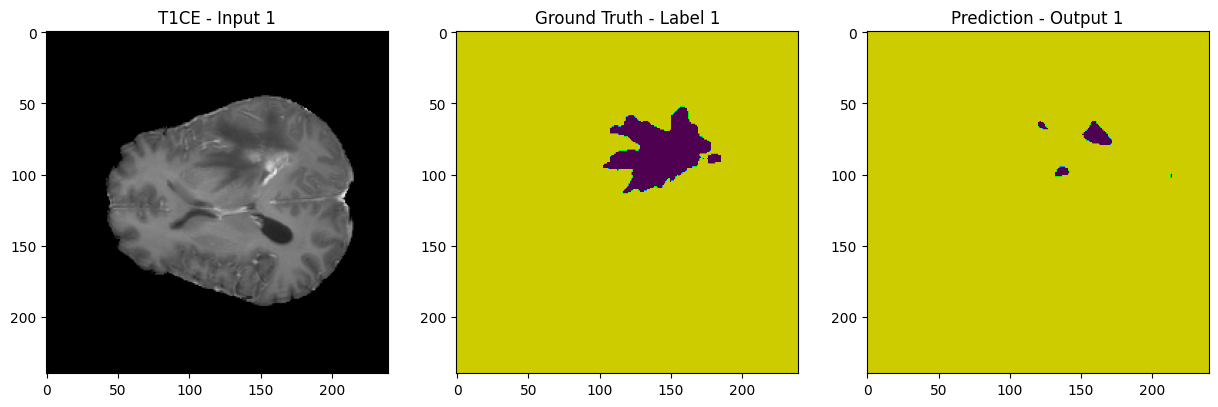

KeyboardInterrupt: 

In [80]:
def plot_segmentation_results(inputs, labels, outputs, idx):
    # Display an image slice with the prediction and ground truth
    slice_idx = inputs.shape[4] // 2  # Use middle slice for visualization

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    cmap = matplotlib.colors.ListedColormap(['#500050', '#0096FF', '#00FF00', '#CCCC00'])
    
    # Plot original T1CE image
    ax[0].imshow(inputs[0, 0, :, :, slice_idx].cpu(), cmap='gray')
    ax[0].set_title(f'T1CE - Input {idx+1}')
    
    # Plot ground truth
    ax[1].imshow(labels[0, 0, :, :, slice_idx].cpu(), cmap=cmap)
    ax[1].set_title(f'Ground Truth - Label {idx+1}')
    
    # Plot model prediction
    ax[2].imshow(outputs[0][0, :, :, slice_idx].cpu(), cmap=cmap)
    ax[2].set_title(f'Prediction - Output {idx+1}')
    
    plt.show()

# After each batch or at the end of testing
for idx, test_data in enumerate(test_loader):
    test_inputs = torch.cat([test_data['t1ce'].to(device), test_data['flair'].to(device)], dim=1)
    test_labels = test_data['seg'].to(device)
    outputs = model(test_inputs)
    outputs = [post_trans(i) for i in decollate_batch(outputs)]
    
    plot_segmentation_results(test_inputs, test_labels, outputs, idx)


### Compute precision and recall

In [83]:
# Compute precision and recall

for idx, test_data in enumerate(test_loader):
    test_inputs = torch.cat([test_data['t1ce'].to(device), test_data['flair'].to(device)], dim=1)
    test_labels = test_data['seg'].to(device)
    outputs = model(test_inputs)
    outputs = [post_trans(i) for i in decollate_batch(outputs)]
    print(len(outputs))
    print(len(test_labels))
    precision = compute_confusion_matrix_metric(outputs, test_labels, metric_name="precision")
    recall = compute_confusion_matrix_metric(outputs, test_labels, metric_name="recall")

    print(f"Precision: {precision.mean().item():.4f}")
    print(f"Recall: {recall.mean().item():.4f}")


2
2


TypeError: compute_confusion_matrix_metric() got multiple values for argument 'metric_name'

### Confusion Matrix for segmentation

In [ ]:
# Assuming you have outputs and test_labels in the proper format (flattened, binary)
y_pred = outputs.flatten().cpu().numpy()
y_true = test_labels.flatten().cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
